In [74]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import massfuncc as mf
importlib.reload(mf)
import astropy.units as u
from scipy.integrate import quad,quad_vec
from scipy.optimize import fsolve,root_scalar
import pandas as pd
from joblib import Parallel, delayed

cosmo = mf.SFRD()
m_H = (cosmo.mHu.to(u.M_sun)).value #M_sun
omega_b = cosmo.omegab
omega_m = cosmo.omegam
rhom = cosmo.rhom

$$\frac{dn}{dM}(M, z|\delta_R, M_R) = \sqrt{\frac{1}{2\pi}} \frac{\rho_m(1 + \delta_R)}{M} \frac{d\sigma^2_1(M, M_R)}{dM} \frac{\delta_1(z, \delta_R)}{\sigma^3_1(M, M_R)} \exp\left(-\frac{\delta^2_1(z, \delta_R)}{2\sigma^2_1(M, M_R)}\right)$$

$$
\sigma_{1}^{2}(M,M_{R}) = \sigma^{2}(M) - \sigma^{2}(M_{R})
$$
$$
\delta_{1}(z,\delta_{R}) = \delta_{c}(z) - \delta_{L}(z,\delta_{R})
$$
$$
\delta_{L}(z,\delta_{R}) = \left[1.68647 - \frac{1.35}{(1 + \delta_{R})^{2/3}} - \frac{1.12431}{(1+\delta_{R})^{0.5}} + \frac{0.78785}{(1+\delta_{R})^{0.58661}}\right]\frac{1}{D(z)}
$$

In [90]:
class Barrier:

    def __init__(self,fesc=0.4, qion=20000,z_v=12.0,nrec=3):
        self.fesc = fesc
        self.qion = qion
        self.z = z_v
        self.nrec = nrec

    # def delta_L(self,deltar):
    #     return (1.68647 - 1.35/(1 + deltar)**(2/3) - 1.12431/(1 + deltar)**(1/2) + 0.78785/(1 + deltar)**(0.58661)) / cosmo.Dz(self.z)

    # def dndm(self,M,Mr,deltar):
    #     delta_L = (  1.68647-1.35/(1+deltar)**(2/3) -1.12431/(1+deltar)**(1/2) +0.78785/(1+deltar)**(0.58661) )/cosmo.Dz(self.z)
    #     sig1 = cosmo.sigma2_interpolation(M)-cosmo.sigma2_interpolation(Mr)
    #     del1 = cosmo.deltac(self.z) - delta_L
    #     return rhom*(1+deltar)/M /np.sqrt(2*np.pi) * abs(cosmo.dsig2dm_interpolation(M))*del1/sig1**(3/2) * np.exp(-del1**2/(2*sig1))

    def Nion_diff(self,m,Mv,deltaR):
        # fstar = cosmo.fstar(m)
        fstar = 0.05
        return self.fesc*self.qion/m_H *fstar* omega_b/omega_m *m*cosmo.dndmeps(m,Mv,deltaR,self.z)

    def Nion(self,Mv,delta_R):
        m_min = cosmo.M_vir(0.61,1e4,self.z)
        m_slice = np.linspace(m_min, Mv, 12)
        ans = np.zeros_like(delta_R)
        for i in range(len(m_slice)-1):
            ans += quad_vec(self.Nion_diff, m_slice[i],m_slice[i+1], args=(Mv,delta_R,))[0]
        return ans

    def N_H(self,deltaR):
        return 1/m_H * omega_b/omega_m * rhom *(1+cosmo.delta_L(deltaR,self.z)) 

    def Calcul_deltaVM_EQ(self,deltaR,Mv):
        return self.Nion(Mv,deltaR) - (1+self.nrec)*self.N_H(deltaR)

    def Calcul_deltaVM(self,Mv):
        result = root_scalar(self.Calcul_deltaVM_EQ, args=(Mv,), bracket=[0.05, 1.7], method='bisect')
        return result.root

    def Calcul_deltaVM_Parallel(self,Mv_array):
        results = Parallel(n_jobs = -1)(delayed(self.Calcul_deltaVM)(Mv) for Mv in Mv_array)
        return np.array(results)
    

In [91]:
bar = Barrier()
deltaR = np.linspace(0, 1.68, 100)
NH_values = (1+bar.nrec)*bar.N_H(deltaR)
detaLs = cosmo.delta_L(deltaR, bar.z)
Nion_values_15 = bar.Nion(1e15, deltaR)
Nion_values_14 = bar.Nion(1e14, deltaR)
Nion_values_13 = bar.Nion(1e13, deltaR)
Nion_values_12 = bar.Nion(1e12, deltaR)
Nion_values_11 = bar.Nion(1e11, deltaR)
Nion_values_10 = bar.Nion(1e10, deltaR)
Nion_values_09 = bar.Nion(1e09, deltaR)

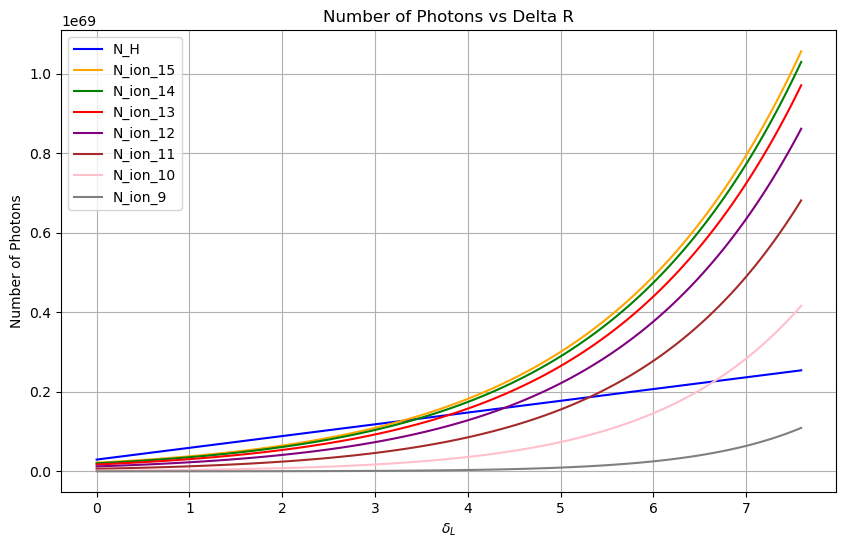

In [92]:
plt.figure(figsize=(10, 6))
plt.plot(detaLs, NH_values, label='N_H', color='blue')
plt.plot(detaLs, Nion_values_15, label='N_ion_15', color='orange')
plt.plot(detaLs, Nion_values_14, label='N_ion_14', color='green')
plt.plot(detaLs, Nion_values_13, label='N_ion_13', color='red')
plt.plot(detaLs, Nion_values_12, label='N_ion_12', color='purple')
plt.plot(detaLs, Nion_values_11, label='N_ion_11', color='brown')
plt.plot(detaLs, Nion_values_10, label='N_ion_10', color='pink')
plt.plot(detaLs, Nion_values_09, label='N_ion_9', color='gray')
plt.xlabel(r'$\delta_L$')
plt.ylabel('Number of Photons')
plt.title('Number of Photons vs Delta R')
plt.legend()
plt.grid()
plt.show()

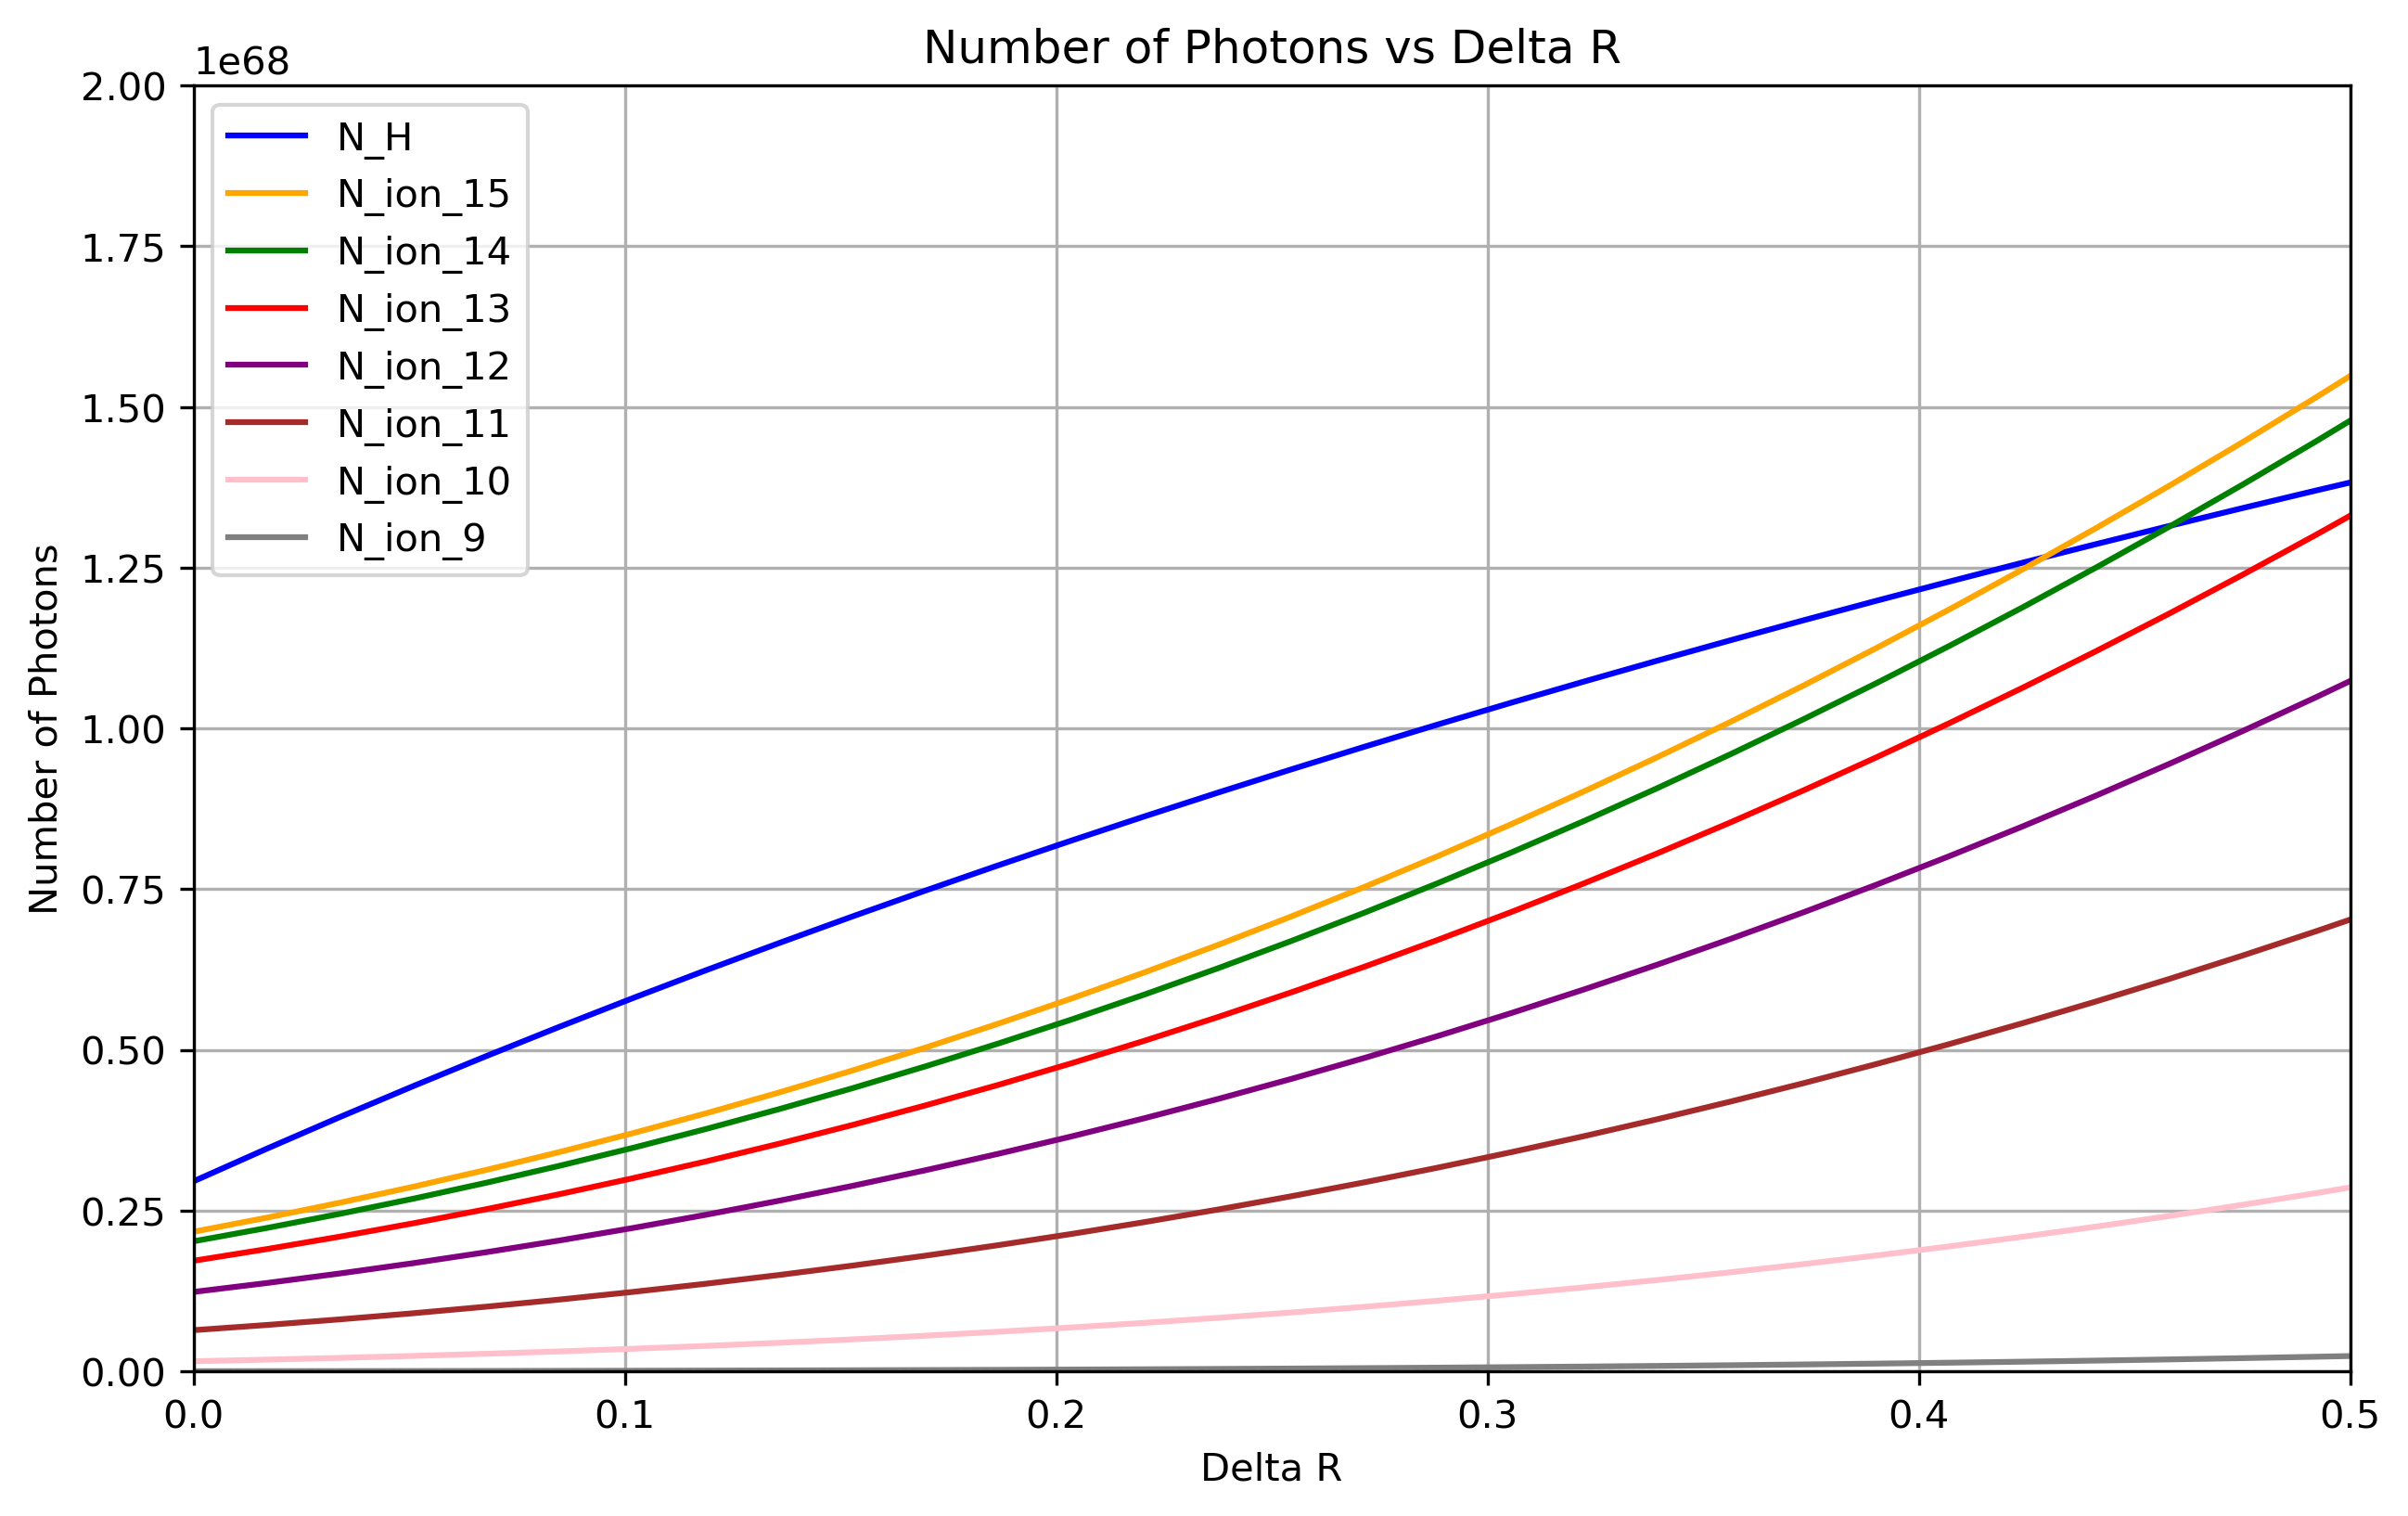

In [62]:
plt.figure(figsize=(10, 6),dpi=300)
plt.plot(deltaR, NH_values, label='N_H', color='blue')
plt.plot(deltaR, Nion_values_15, label='N_ion_15', color='orange')
plt.plot(deltaR, Nion_values_14, label='N_ion_14', color='green')
plt.plot(deltaR, Nion_values_13, label='N_ion_13', color='red')
plt.plot(deltaR, Nion_values_12, label='N_ion_12', color='purple')
plt.plot(deltaR, Nion_values_11, label='N_ion_11', color='brown')
plt.plot(deltaR, Nion_values_10, label='N_ion_10', color='pink')
plt.plot(deltaR, Nion_values_09, label='N_ion_9', color='gray')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Delta R')
plt.ylabel('Number of Photons')
plt.xlim(0, 0.5)
plt.ylim(0,0.2e69)
plt.title('Number of Photons vs Delta R')
plt.legend()
plt.grid()
plt.show()

In [95]:
from joblib import Parallel, delayed
import pickle

# 验证类实例和方法能否被pickle
try:
    pickle.dumps(bar.Calcul_deltaVM_Parallel)
    print("方法可序列化")
except Exception as e:
    print("序列化失败:", str(e))  # 常见于包含不可序列化对象（如文件句柄）

方法可序列化


In [ ]:
Mvs = np.logspace(10, 15, 100)
delta_values = bar.Calcul_deltaVM_Parallel(Mvs)

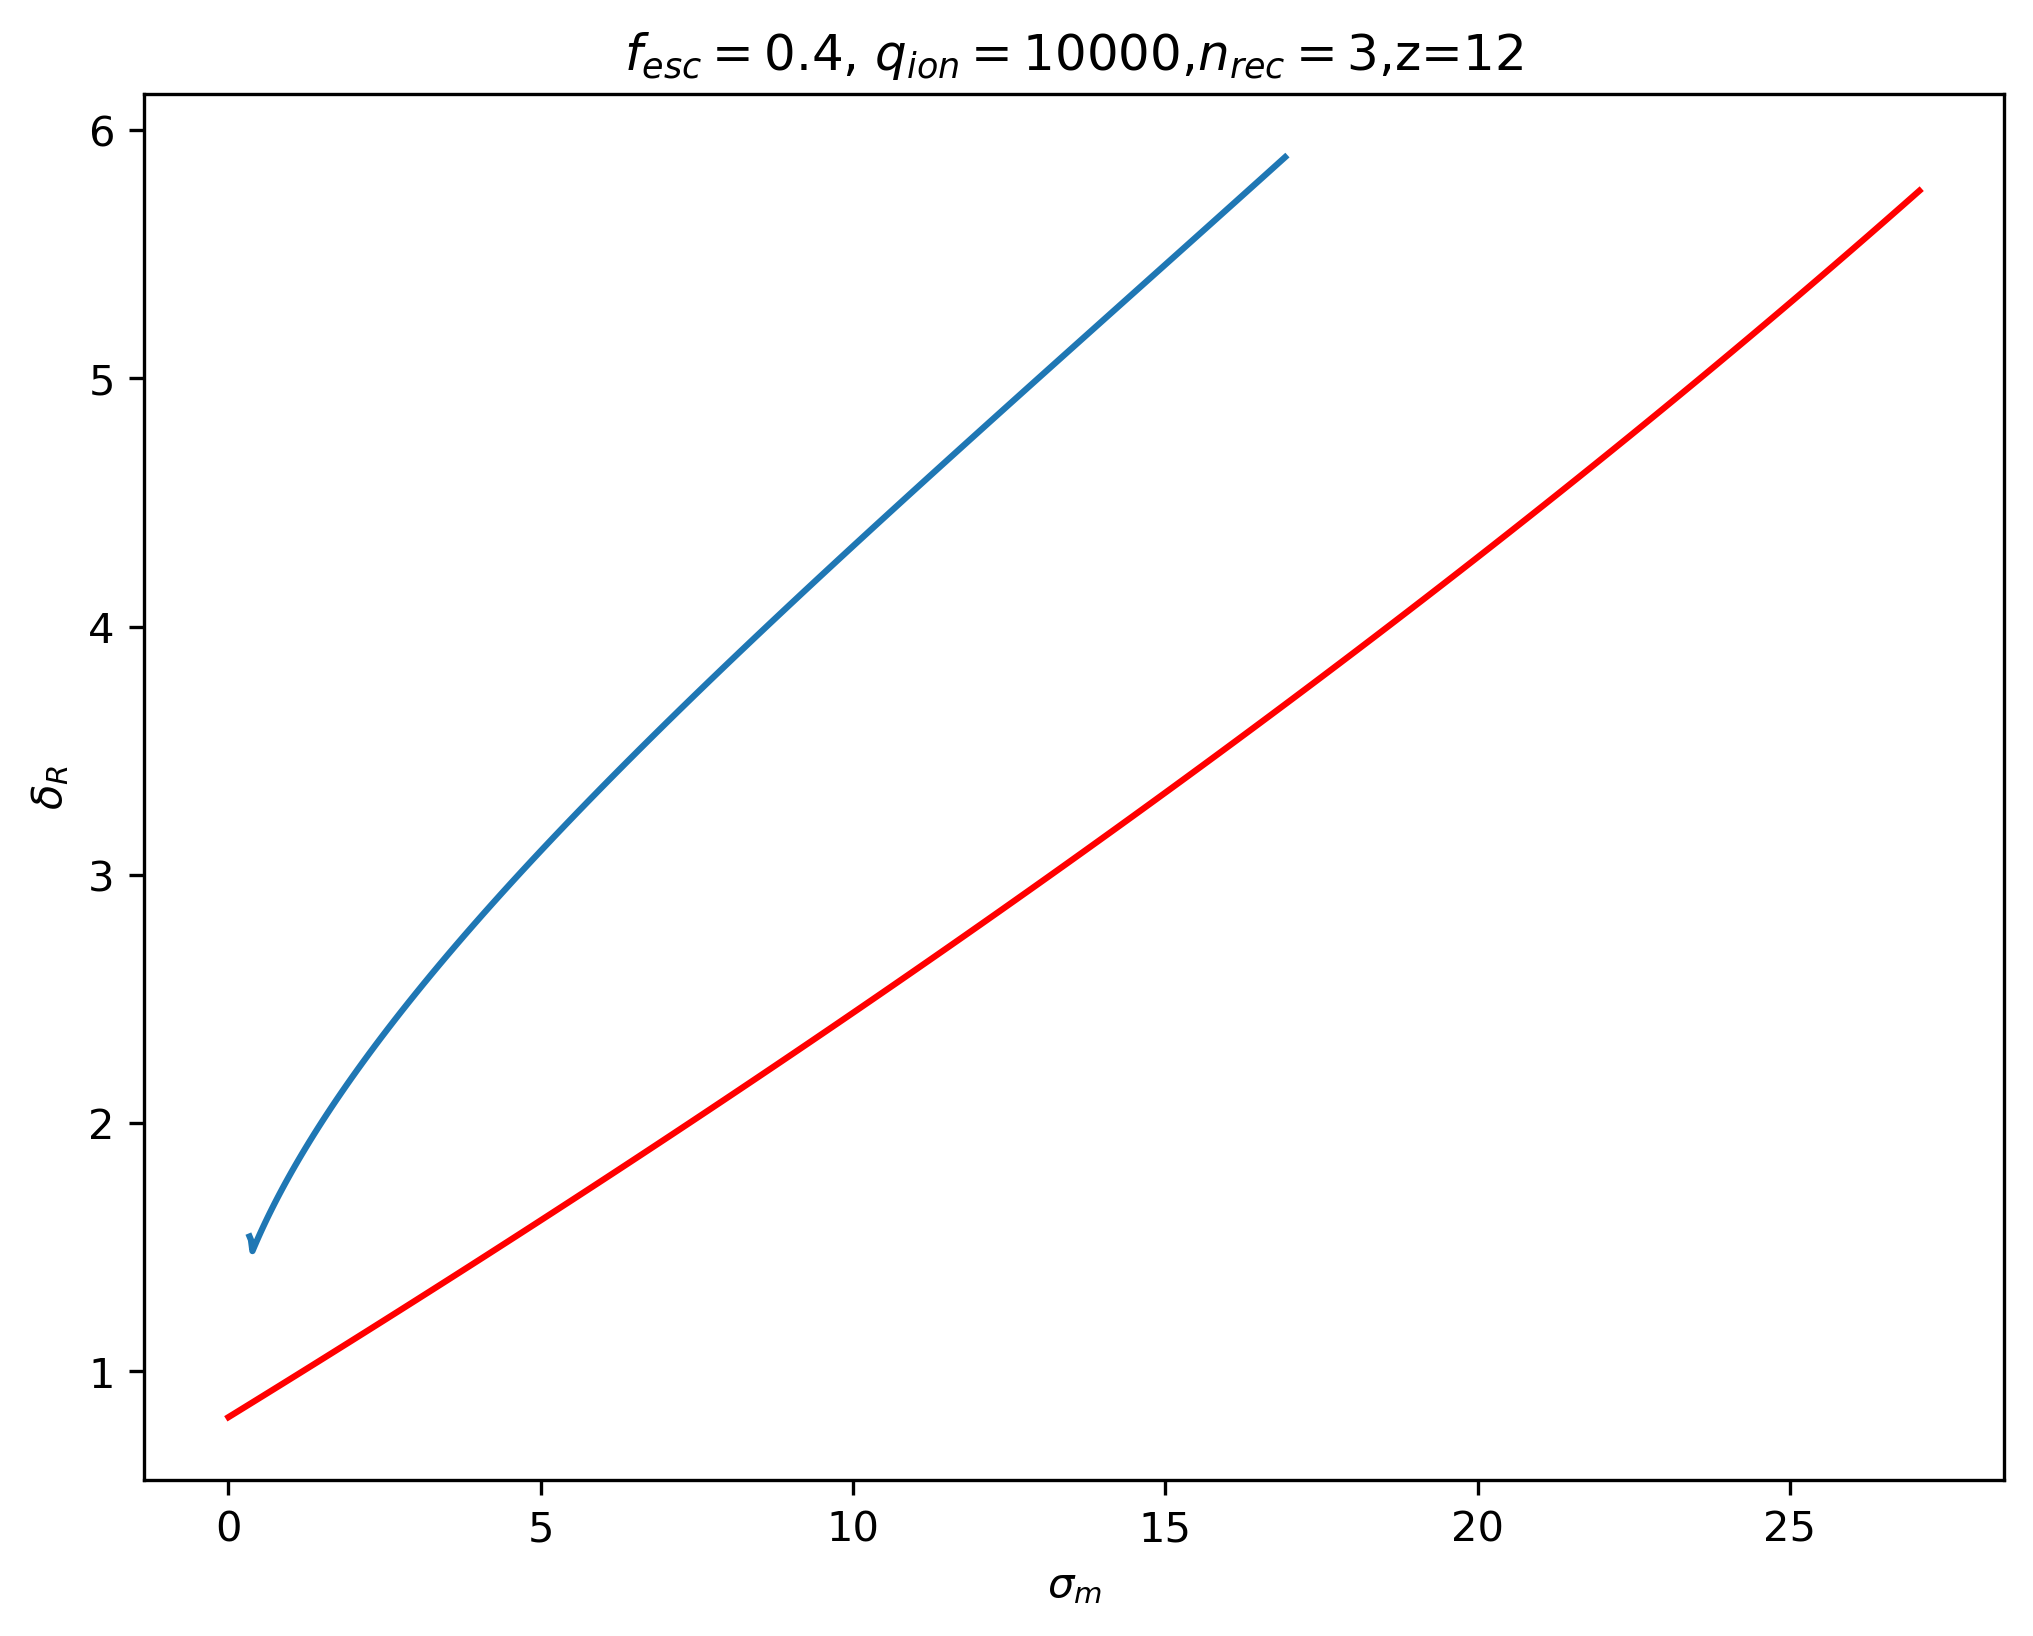

In [17]:
plt.figure(figsize=(8, 6),dpi=300)


# Read the CSV file
bubble_data = pd.read_csv('/home/zhuhourui/AstroCode/bubbleM/bubble_barriers.csv')

# Display the first few rows to verify the data
bubble_data.head()
B_data = pd.read_csv('/home/zhuhourui/AstroCode/bubbleM/bubble_B.csv')
B_data.head()


plt.plot(bubble_data['sigma2_12'], bubble_data['delta_x_z12'], 
         label=r'$\delta_x, z=12$', color='red')




sigl = np.array([cosmo.sigma2_interpolation(mv) for mv in Mvs])
deltaLvalues = np.array([delta_L(dr) for dr in delta_values])
plt.plot(sigl, deltaLvalues, label='fesc=0.4, qion=10000')
# plt.xscale('log')
# plt.xlim(6e7, 8e7)
plt.ylabel(r'$\delta_R$')
plt.xlabel(r'$\sigma_m$')
plt.title(r'$f_{esc}=0.4$, $q_{ion}=10000$,$n_{rec} = 3$,z=12')
plt.savefig('delta_R.png',dpi=300)